# Ramen Analysis

This dataset on ramen noodle reviews comes from Kaggle. It contains information about the brand of ramen, a description about the flavor variety, the preparation, country of origin, and its star rating from 0-5. We'll take a look at what makes a good bowl of instant ramen, and build a random forest model to see which factors are most important to receive a good review.

## Data Prep

In [796]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn
import shap

In [797]:
ramen = pd.read_csv('X:/Documents/Data/ramen-ratings.csv')
countries = gpd.read_file('X:/Documents/Shapes/world_countries.shp')

#Remove unrated ramen from the dataset, there are only 2 rows with no data
ramen = ramen[ramen['Stars']!='Unrated']
ramen['Stars'] = ramen['Stars'].astype('double')

ramen.head()

Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   

                                             Variety Style Country  Stars  \
0                          T's Restaurant Tantanmen    Cup   Japan   3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack  Taiwan   1.00   
2                      Cup Noodles Chicken Vegetable   Cup     USA   2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack  Taiwan   2.75   
4                                    Singapore Curry  Pack   India   3.75   

  Top Ten  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

### Subsetting on brands
Taking a quick look at the number of brands represented, there are very many. We'll focus primarily on the brands with the most number of reviews so we can get meaningful insights.

In [798]:
ramen['Brand'].describe()

count       2577
unique       355
top       Nissin
freq         381
Name: Brand, dtype: object

Nissin is the brand with the most number of reviews, and we'll take the top 50. The minimum number of reviews by brand is 11.

In [799]:
ramen.groupby('Brand', as_index=False).count().sort_values(by='Review #', ascending=False).iloc[:50, 0:2]

Brand  Review #
192            Nissin       381
195          Nongshim        98
160          Maruchan        76
157              Mama        71
208             Paldo        66
183             Myojo        63
110           Indomie        53
249     Samyang Foods        51
206            Ottogi        45
330      Vina Acecook        34
153         Lucky Me!        34
329             Vifon        33
155             Maggi        30
159             Mamee        29
162       Master Kong        28
154              MAMA        27
4    A-Sha Dry Noodle        26
254   Sapporo Ichiban        25
120              KOKA        25
332           Wai Wai        25
181           MyKuali        24
327           Ve Wong        24
116               JML        23
248           Samyang        19
134              Koka        18
23         Batchelors        16
52               Doll        16
123            Kamfen        15
336           Wei Lih        15
177       Mr. Noodles        15
7             Acecook        15
289    Takamori Kosan        14
16   Asian Thai Foods        14
147       Little Cook        14
256           Sau Tao        14
51            Deshome        13
331             Vit's        13
240    Saigon Ve Wong        13
55          Dragonfly        13
319              Unif        13
350           Yum Yum        12
13       Annie Chun's        12
6                 ABC        12
342             Wu-Mu        12
84       Golden Wheat        12
168         Mi Sedaap        12
318     Uni-President        12
219        Pot Noodle        11
262         Shirakiku        11
320     Unif / Tung-I        11

In [800]:
brands_list = list(ramen.groupby('Brand', as_index=False).count().sort_values(by='Review #', ascending=False).iloc[:50,0])

#Subset to just the top 50 brands
ramen = ramen[ramen['Brand'].isin(brands_list)]

ramen

Review #          Brand  \
2         2578         Nissin   
3         2577        Wei Lih   
5         2575  Samyang Foods   
6         2574        Acecook   
9         2571           KOKA   
...        ...            ...   
2574         6          Vifon   
2575         5          Vifon   
2576         4        Wai Wai   
2577         3        Wai Wai   
2578         2        Wai Wai   

                                                Variety Style      Country  \
2                         Cup Noodles Chicken Vegetable   Cup          USA   
3                         GGE Ramen Snack Tomato Flavor  Pack       Taiwan   
5                                Kimchi song Song Ramen  Pack  South Korea   
6                   Spice Deli Tantan Men With Cilantro   Cup        Japan   
9                 The Original Spicy Stir-Fried Noodles  Pack    Singapore   
...                                                 ...   ...          ...   
2574                                           Nam Vang  Pack      Vietnam   
2575  Hu Tiu Nam Vang ["Phnom Penh" style] Asian Sty...  Bowl      Vietnam   
2576                     Oriental Style Instant Noodles  Pack     Thailand   
2577                                     Tom Yum Shrimp  Pack     Thailand   
2578                               Tom Yum Chili Flavor  Pack     Thailand   

      Stars Top Ten  
2      2.25     NaN  
3      2.75     NaN  
5      4.75     NaN  
6      4.00     NaN  
9      2.50     NaN  
...     ...     ...  
2574   2.50     NaN  
2575   3.50     NaN  
2576   1.00     NaN  
2577   2.00     NaN  
2578   2.00     NaN  

[1658 rows x 7 columns]

## Exploratory analysis
We'll examine how different features such as brand, country of origin, and flavor variety influence ratings

### Brand

We can see that MyKuali, a Thai brand of instant noodle, is the most highly rated brand of ramen. Mr. Noodles is the worst rated on average. My favorite brand of ramen, Sapporo Ichiban, is in the middle of the pack. It beats out popular American brand Maruchan, but is not as good as the most popular brand worldwide Nissin.

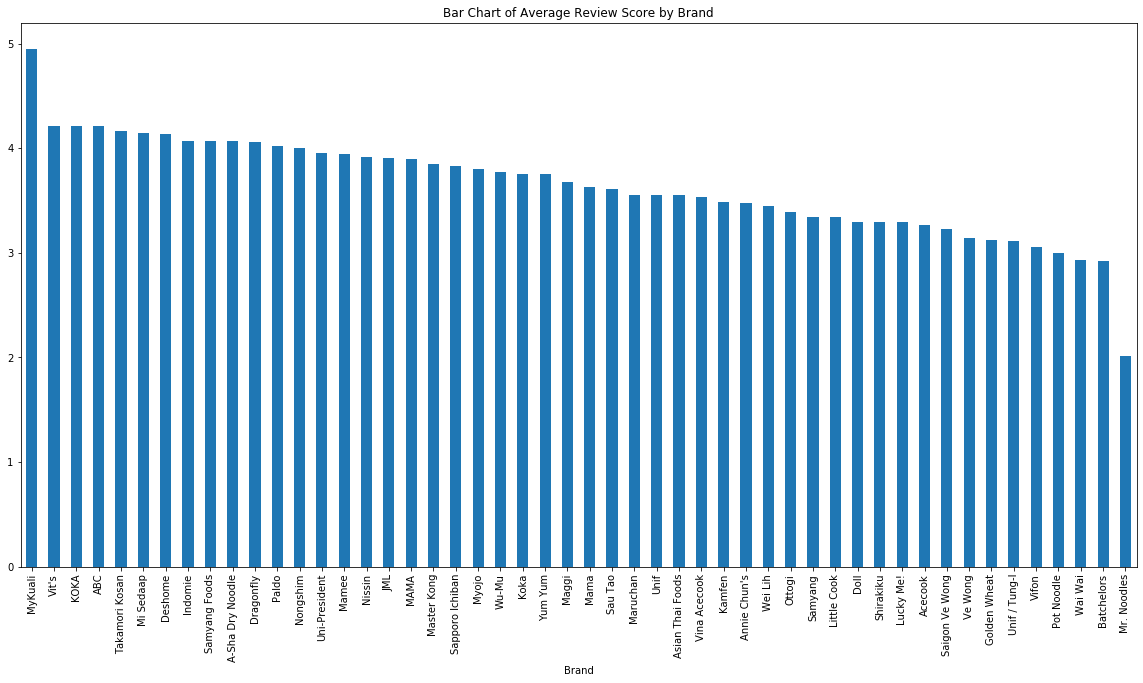

In [801]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Bar Chart of Average Review Score by Brand")
ramen.groupby('Brand')['Stars'].mean().sort_values(ascending=False).plot.bar(ax=ax)

### Countries
Surprisingly, South Korean ramen has the highest number of reviews in our set beating out Japan and America. We'll map this to see which regions have the most reviews for their ramen.

In [802]:
#Aggregate and get count of reviews
countries_count_df = ramen.groupby('Country', as_index=False)['Stars'].count().sort_values(by='Stars', ascending=False)
countries_count_df = countries_count_df.rename(columns={'Stars':'Review Count'})

#Aggregate and get mean star rating
countries_stars_df = ramen.groupby('Country', as_index=False)['Stars'].mean().sort_values(by='Stars', ascending=False)

In [803]:
countries.head()

OBJECTID           CNTRY_NAME  \
0         1                Aruba   
1         2  Antigua and Barbuda   
2         3          Afghanistan   
3         4              Algeria   
4         5           Azerbaijan   

                                            geometry  
0  POLYGON ((-69.88223 12.41111, -69.94695 12.436...  
1  MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...  
2  POLYGON ((61.27656 35.60725, 61.29638 35.62853...  
3  POLYGON ((-5.15213 30.18047, -5.13917 30.19236...  
4  MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...

In [804]:
#Merge count df onto the shapefile
countries_count = countries.merge(countries_count_df, left_on='CNTRY_NAME', right_on='Country')
countries_count = countries_count.drop(columns='Country')

#Create a list of countries with > 4 reviews to subset both geodataframes
countries_subset = list(countries_count[countries_count['Review Count'] > 4]['CNTRY_NAME'])

#Merge stars mean df onto the shapefile
countries_stars = countries.merge(countries_stars_df, left_on='CNTRY_NAME', right_on='Country')
countries_stars = countries_stars.drop(columns='Country')
countries_stars['Stars']=countries_stars['Stars'].fillna(0)

#Subset geodataframes
countries_count = countries_count[countries_count['CNTRY_NAME'].isin(countries_subset)]
countries_stars = countries_stars[countries_stars['CNTRY_NAME'].isin(countries_subset)]

We can see from the map that Asian brands represent the most number of reviews for our top brands in the set.

In [805]:
countries_count[['CNTRY_NAME', 'Review Count']].sort_values(by='Review Count', ascending=False)

CNTRY_NAME  Review Count
13  South Korea           232
12        Japan           229
21     Thailand           138
22       Taiwan           120
5         China            97
20    Singapore            92
24      Vietnam            84
10    Indonesia            78
15     Malaysia            70
19  Philippines            35
14       Mexico            24
11        India            23
8       Germany            22
3        Canada            16
17        Nepal            14
6      Colombia             6
2        Brazil             5
4      Cambodia             5
1    Bangladesh             5

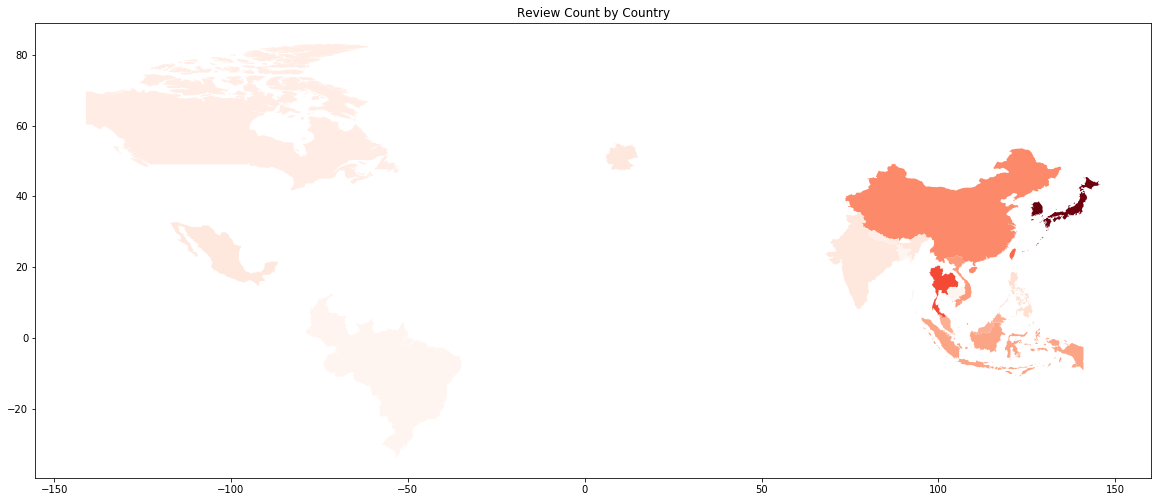

In [823]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Review Count by Country") 
countries_count.plot(figsize=(20,15),column='Review Count', cmap='Reds', ax=ax)

Interestingly, Brazil has the highest average rating for their ramen. This is likely because we only have 5 reviews of Brazilian ramen in the dataset. After Brazil, Asian brands are strongly represented at the top. Malaysia has 70 reviews in the set, so we can trust their high score a little more than Brazil's. Canada, unsurprisingly, has the worst ramen in the set.

In [807]:
countries_stars[['CNTRY_NAME', 'Stars']].sort_values(by='Stars', ascending=False)

CNTRY_NAME     Stars
2        Brazil  4.350000
15     Malaysia  4.302143
4      Cambodia  4.200000
10    Indonesia  4.131410
20    Singapore  4.076087
12        Japan  4.007751
13  South Korea  3.850000
14       Mexico  3.760417
5         China  3.703608
22       Taiwan  3.696667
8       Germany  3.693182
1    Bangladesh  3.600000
17        Nepal  3.553571
21     Thailand  3.503623
6      Colombia  3.291667
19  Philippines  3.257143
11        India  3.250000
24      Vietnam  3.235714
3        Canada  2.203125

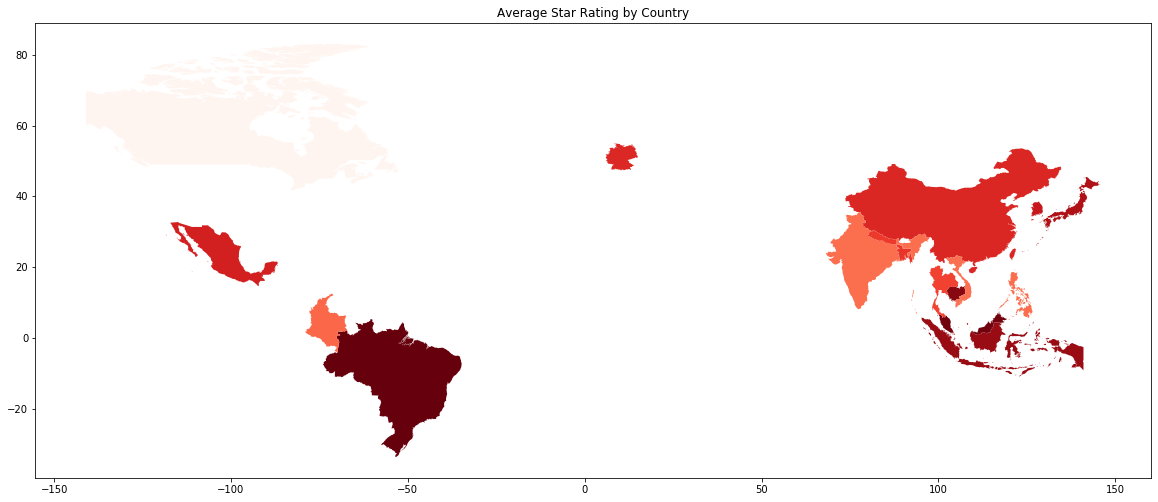

In [824]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Average Star Rating by Country") 
countries_stars.plot(figsize=(20,15),column='Stars', cmap='Reds', ax=ax)

### Flavors
We will examine which words in the description of the variety are most correlated with high reviews. 

In [809]:
from collections import Counter
from nltk.corpus import stopwords

#Get stopwords from a package, and then add some ramen specific stop words to it 
stop = stopwords.words('english')
customstop = ['Noodles', 'Noodle', 'Instant', 'Flavour', 'Flavor', 'Ramen', 'Cup', 'Artificial'
               ,'Sauce', 'Rice', 'Big', 'Super', 'Sabor', 'Nissin', 'Top', 'Base', 'Black', 'Soup' 
               ,'With', 'Bowl', 'Style', '&', 'A', 'Of', 'Sopa', 'Minute', 'Taste']
stop = stop + customstop

#Remove stopwords from the pandas series
words_series = ramen['Variety'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

#Count most popular words
top50 = Counter([word for line in list(words_series) for word in line.split()]).most_common(50)

#Create a list of the top words by breaking the tuples
top50list = []

for i in range(0, len(top50)):
    top50list.append(top50[i][0])
top50

[('Chicken', 219),
 ('Spicy', 191),
 ('Beef', 155),
 ('Shrimp', 92),
 ('Tom', 82),
 ('Seafood', 81),
 ('Pork', 77),
 ('Mi', 70),
 ('Hot', 69),
 ('Curry', 65),
 ('Yum', 59),
 ('Demae', 58),
 ('Goreng', 51),
 ('Yakisoba', 42),
 ('Udon', 41),
 ('Tonkotsu', 37),
 ('Ramyun', 37),
 ('Vermicelli', 35),
 ('Oriental', 35),
 ('Kimchi', 34),
 ('Chow', 32),
 ('Vegetable', 31),
 ('Korean', 31),
 ('Sesame', 31),
 ('Penang', 29),
 ('Mein', 29),
 ('King', 28),
 ('Fried', 27),
 ('Tomato', 26),
 ('Soy', 26),
 ('Rasa', 26),
 ('Mushroom', 25),
 ('Onion', 24),
 ('Japanese', 24),
 ('Snack', 23),
 ('Creamy', 23),
 ('Kung', 23),
 ('Chili', 22),
 ('Sour', 21),
 ('Iccho', 21),
 ('Cheese', 21),
 ('Crab', 20),
 ('Shoyu', 20),
 ('Fu', 20),
 ('Yam', 19),
 ('Laksa', 18),
 ('Chilli', 18),
 ('Soba', 18),
 ('Oil', 18),
 ('Original', 17)]

From the above list of tuples we can see Chicken, Spicy, and Beef are the top three most popular descriptors.

Penang and Laksa are the two most highly rated descriptors in the set, and they appear relatively often in the set. These are both associated with Thai cuisine, I'll have to try Thai ramen!

In [810]:
ramen[ramen['Variety'].str.contains(top50list[0])]

words =[]
means = []

#Create a dataframe of mean review score by flavor descriptors
for word in top50list:
    temp = ramen[ramen['Variety'].str.contains(word)]
    words.append(word)
    means.append(temp['Stars'].mean())

wordsdict = {
    'Word':words,
    'Mean':means
}

wordsdf = pd.DataFrame.from_dict(wordsdict)

wordsdf.sort_values(by='Mean', ascending=False)

Word      Mean
24      Penang  4.956897
45       Laksa  4.555556
12      Goreng  4.375000
35      Creamy  4.347826
15    Tonkotsu  4.190278
27       Fried  4.182432
9        Curry  4.157692
16      Ramyun  4.026923
10         Yum  4.013115
30        Rasa  3.990385
47        Soba  3.962500
42       Shoyu  3.950000
39       Iccho  3.928571
40      Cheese  3.916667
13    Yakisoba  3.904762
7           Mi  3.904739
23      Sesame  3.875000
4          Tom  3.855752
5      Seafood  3.853659
44         Yam  3.850000
26        King  3.848485
49    Original  3.823529
14        Udon  3.808140
11       Demae  3.801724
1        Spicy  3.791888
20        Chow  3.765625
17  Vermicelli  3.757353
19      Kimchi  3.747059
8          Hot  3.739726
25        Mein  3.731481
34       Snack  3.728261
48         Oil  3.722222
46      Chilli  3.680556
41        Crab  3.675000
28      Tomato  3.673077
29         Soy  3.635135
38        Sour  3.630952
2         Beef  3.603734
33    Japanese  3.600000
32       Onion  3.576000
3       Shrimp  3.560526
21   Vegetable  3.519737
6         Pork  3.495833
22      Korean  3.484375
0      Chicken  3.439706
43          Fu  3.384615
37       Chili  3.318182
18    Oriental  3.300000
36        Kung  3.278846
31    Mushroom  3.000000

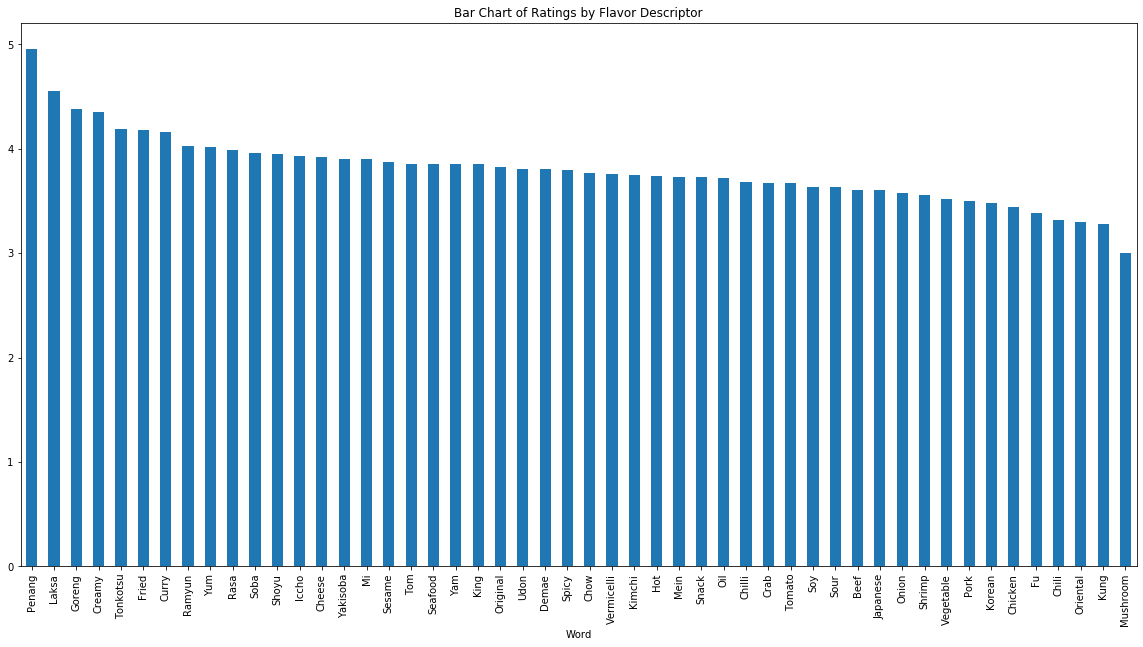

In [811]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Bar Chart of Ratings by Flavor Descriptor")
wordsdf = wordsdf.sort_values(by='Mean', ascending=False)
wordsdf = wordsdf.set_index('Word')
wordsdf['Mean'].plot.bar(ax=ax)

## Modeling
We'll build a random forest model to explain the most important factors in a highly rated bowl of ramen. We will explain the model using feature importance and shap values.

### Model Setup

From the start, we can see that the distribution of rating stars has a strong left skew. Very few ratings are below 3, and there are many above 3.5 stars. This may make our model less accurate, even though random forests are fairly resilient to skewed response variables.

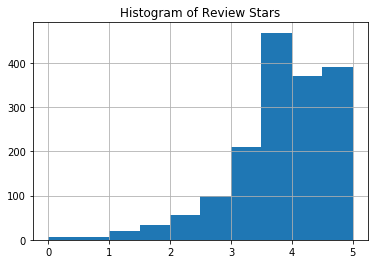

In [812]:
plt.title("Histogram of Review Stars")
hist=ramen['Stars'].hist(bins=10)
hist

In [813]:
#Create dummy variables to use in the model
for country in ramen['Country'].unique():
    ramen['From_'+country] = ramen['Country'].str.contains(country).astype(int)
for brand in ramen['Brand'].unique():
    ramen['From_'+brand] = ramen['Brand'].str.contains(brand).astype(int)
for word in top50list:
    ramen['Contains_'+word] = ramen['Variety'].str.contains(word).astype(int)
for style in ramen['Style']:
    ramen['Style'] = ramen['Style'].fillna('Missing')
    ramen['Style_'+style] = ramen['Style'].str.contains(style).astype(int)

ramen

Review #          Brand  \
2         2578         Nissin   
3         2577        Wei Lih   
5         2575  Samyang Foods   
6         2574        Acecook   
9         2571           KOKA   
...        ...            ...   
2574         6          Vifon   
2575         5          Vifon   
2576         4        Wai Wai   
2577         3        Wai Wai   
2578         2        Wai Wai   

                                                Variety Style      Country  \
2                         Cup Noodles Chicken Vegetable   Cup          USA   
3                         GGE Ramen Snack Tomato Flavor  Pack       Taiwan   
5                                Kimchi song Song Ramen  Pack  South Korea   
6                   Spice Deli Tantan Men With Cilantro   Cup        Japan   
9                 The Original Spicy Stir-Fried Noodles  Pack    Singapore   
...                                                 ...   ...          ...   
2574                                           Nam Vang  Pack      Vietnam   
2575  Hu Tiu Nam Vang ["Phnom Penh" style] Asian Sty...  Bowl      Vietnam   
2576                     Oriental Style Instant Noodles  Pack     Thailand   
2577                                     Tom Yum Shrimp  Pack     Thailand   
2578                               Tom Yum Chili Flavor  Pack     Thailand   

      Stars Top Ten  From_USA  From_Taiwan  From_South Korea  ...  \
2      2.25     NaN         1            0                 0  ...   
3      2.75     NaN         0            1                 0  ...   
5      4.75     NaN         0            0                 1  ...   
6      4.00     NaN         0            0                 0  ...   
9      2.50     NaN         0            0                 0  ...   
...     ...     ...       ...          ...               ...  ...   
2574   2.50     NaN         0            0                 0  ...   
2575   3.50     NaN         0            0                 0  ...   
2576   1.00     NaN         0            0                 0  ...   
2577   2.00     NaN         0            0                 0  ...   
2578   2.00     NaN         0            0                 0  ...   

      Contains_Chilli  Contains_Soba  Contains_Oil  Contains_Original  \
2                   0              0             0                  0   
3                   0              0             0                  0   
5                   0              0             0                  0   
6                   0              0             0                  0   
9                   0              0             0                  1   
...               ...            ...           ...                ...   
2574                0              0             0                  0   
2575                0              0             0                  0   
2576                0              0             0                  0   
2577                0              0             0                  0   
2578                0              0             0                  0   

      Style_Cup  Style_Pack  Style_Bowl  Style_Tray  Style_Box  Style_Missing  
2             1           0           0           0          0              0  
3             0           1           0           0          0              0  
5             0           1           0           0          0              0  
6             1           0           0           0          0              0  
9             0           1           0           0          0              0  
...         ...         ...         ...         ...        ...            ...  
2574          0           1           0           0          0              0  
2575          0           0           1           0          0              0  
2576          0           1           0           0          0              0  
2577          0           1           0           0          0              0  
2578          0           1           0           0          0              0  

[1658

In [814]:
#Variable to represent how many words are in the flavor description
ramen['Variety_Len'] = ramen['Variety'].str.split().apply(len)

x = ramen.iloc[:,7:]
y = ramen['Stars']

In [815]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.5, random_state=0)

In [816]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_jobs=4, n_estimators=200, max_depth=6, random_state=0)
regressor.fit(x_train,y_train)
y_pred=regressor.predict(x_test)

### Model evaluation
The model isn't performing great, with a RMSE of .867. These means on average we can predict within about a point of where the ratings stars will be. This model isn't very accurate, but I'm still interested to see which variables are most important.

In [817]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred).round(3))
print('MSE:', metrics.mean_squared_error(y_test,y_pred).round(3))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)).round(3))

MAE: 0.633
MSE: 0.752
RMSE: 0.867


### Feature importance

We can see from the feature importance chart that the length of the flavor description is most important for the rating. This makes some sense, "fancier" ramen probably has more nuanced flavor leading to a longer description. Penang, which we saw from exploratory analysis had a very high rating, also makes an appearance as the second most important factor in a rating. Mushroom flavor rounds out the top three. It's interesting to see which variables are the most important, but we don't know if it's more important for a ramen flavor to have mushrooms or not. We will use shap values to explain this.

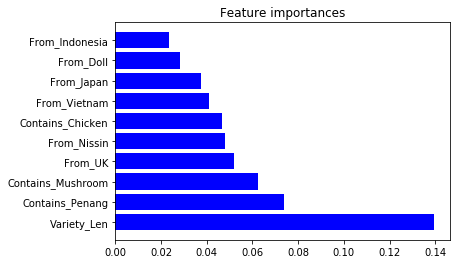

In [818]:
#Get importances from our regressor object
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

#Set up the flot
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(importances[indices])),importances[indices], color ='b', align='center')
plt.yticks(range(len(indices)), [x.columns[i] for i in indices])
plt.show()



Shap values allow us to take a deeper look at the feature importance of the tree. We are looking for variables that create a high amount of segmentation between positive and negative review effects. Since many of our variables are binary 1s and 0s, we can interpret a red dot as a value of '1' and a blue dot as a value of '0'. Looking at Nissin, for instance, we can see that when Nissin is 1 this is associated with a positive impact on review scores. Also interesting, we can see when 'Contains_Mushroom' is 1, this is associated with a lower review score. I love mushrooms! I guess there are a lot of mushroom haters in this dataset.

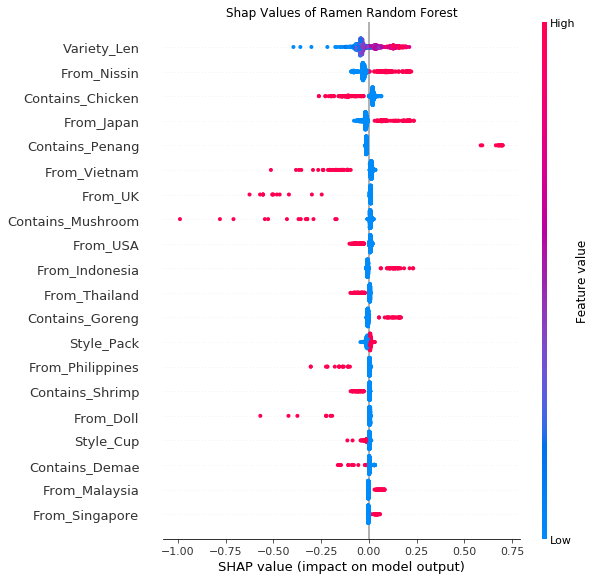

In [819]:
#Plot the Shap values
f = plt.figure()
plt.title("Shap Values of Ramen Random Forest")
shap_values=shap.TreeExplainer(regressor).shap_values(x_train)
shap.summary_plot(shap_values, x_train)

## Conclusion
We can see from this final analysis that our perfect bowl of ramen likely has a long description, is from Nissin, comes in a pack and contains Penang. Some research shows this perfect bowl of instant ramen doesn't actually exist, but I'm definitely interested in trying instant Penang noodles after this analysis. 